In [1]:
# General imports
from tqdm.notebook import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Torch
import torch
import torch.optim as optim
import torch.nn as nn

# Bayes by backprop models
from models.regression import BayesianRegressor, BayesianRegressorHeteroscedastic
# Baselines
from models.baselines import BaselineLinearRegressor, BaselineLinRegressorWithDropout
# Utils
from utils.experiments import experiment
from utils.vis import visualize_training, weights_histogram, visualize_inference, visualize_deterministic, deterministic_histogram
from utils.predictive import mean_var_predictive, ensembles_inference

# Matplotlib utilities
plt.style.use('seaborn-white')

### Defining utilities

Defining device and util variables

In [2]:
# Defining device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# MSE for evaluating regression
mse = nn.MSELoss()
# Settings seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

### Evaluation over priors

Evaluation over all the possible priors with 5 ELBO samples and different mixture
(the same ones defined in the original paper)

The experiment is conducted using the same data as in the original paper. Training over 3000 epochs and 5 Elbo samples.

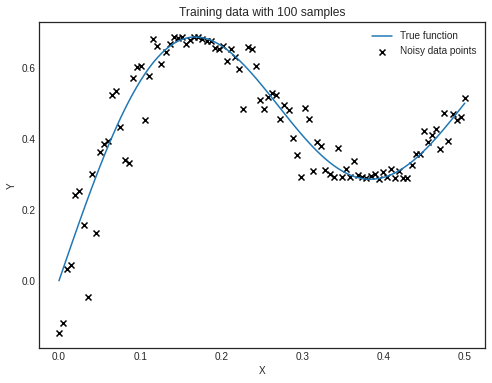

In [3]:
# Defining training and test data
train_samples = 100 # Number of training samples
# Training samples
X_train, y_train = experiment(xmin = 0, xmax = 0.5, samples = train_samples, std = 0.02)
_, y_train_true = experiment(xmin = 0, xmax = 0.5, samples = train_samples, std = 0)
# Test samples (from -0.2 to 1.2)
test_samples = 100
exp_samples = 50
X_test, y_test = experiment(xmin = -0.2, xmax = 1.2, samples = test_samples, std = 0.02)
_, y_test_true = experiment(xmin = -0.2, xmax = 1.2, samples = test_samples, std = 0)

# Visualizing data sample
fig1 = visualize_training(X_train.numpy(), y_train.numpy(), y_train_true.numpy())
fig1.savefig('assets/priors/training.png')

Training the models

### ----------------------------- ###
# -------- Training Normal -------- #
### ----------------------------- ###


  0%|          | 0/3000 [00:00<?, ?it/s]

### ----------------------------- ###
# ------- Evaluation Normal ------- #
### ----------------------------- ###


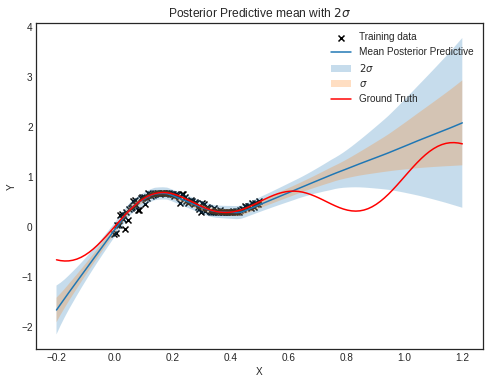

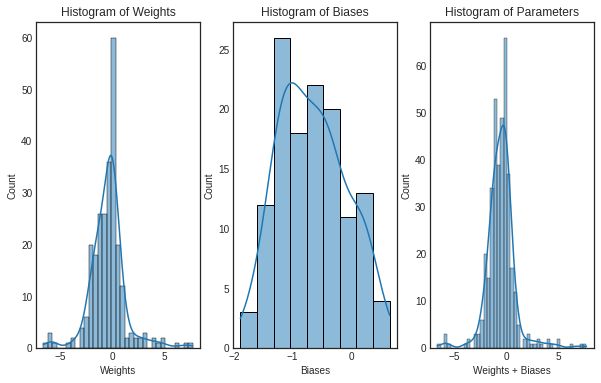

### ----------------------------- ###
# -------- Training Mixture1 -------- #
### ----------------------------- ###


  0%|          | 0/3000 [00:00<?, ?it/s]

### ----------------------------- ###
# ------- Evaluation Mixture1 ------- #
### ----------------------------- ###


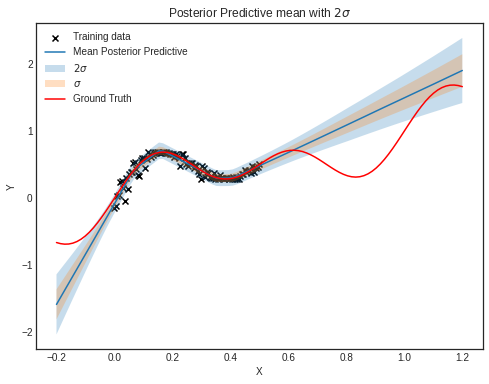

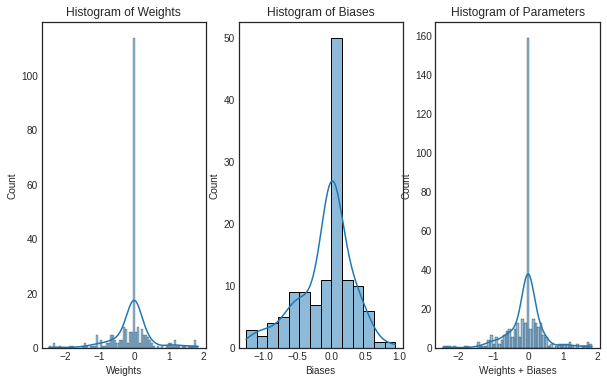

### ----------------------------- ###
# -------- Training Mixture2 -------- #
### ----------------------------- ###


  0%|          | 0/3000 [00:00<?, ?it/s]

### ----------------------------- ###
# ------- Evaluation Mixture2 ------- #
### ----------------------------- ###


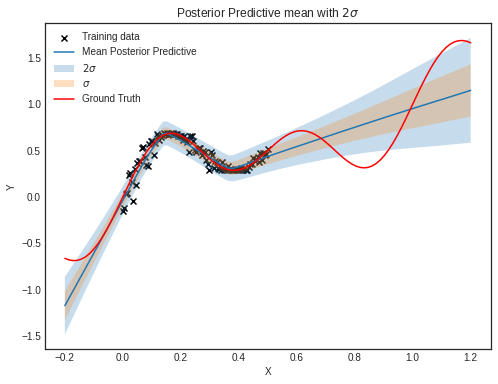

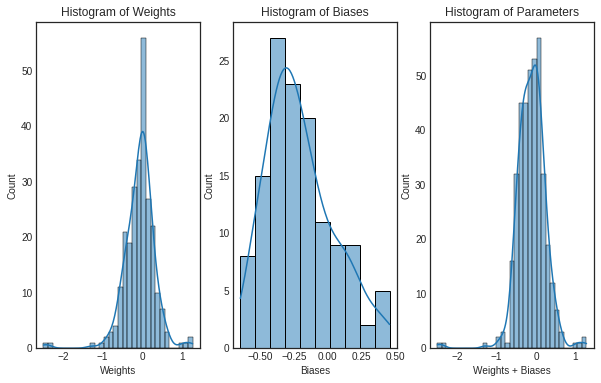

### ----------------------------- ###
# -------- Training Mixture3 -------- #
### ----------------------------- ###


  0%|          | 0/3000 [00:00<?, ?it/s]

### ----------------------------- ###
# ------- Evaluation Mixture3 ------- #
### ----------------------------- ###


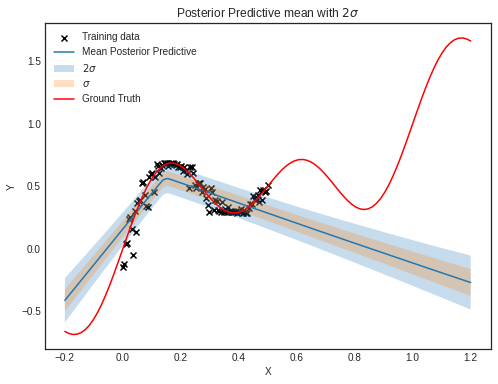

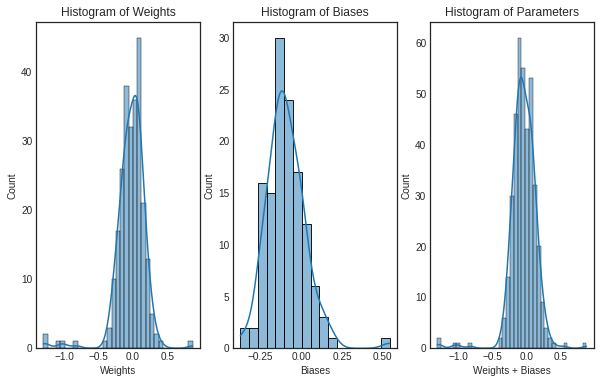

In [4]:
# Experiment params -log\sigma_1, -log\sigma_2, pi, mixture
experiments_prior = {'Normal': (0, 6, 1 / 4, False), 'Mixture1': (0, 6, 1 / 4, True),
                     'Mixture2': (1, 7, 1 / 2, True), 'Mixture3': (2, 8, 3 / 4, True)}
# Defining params
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
# Defining hyper-parameters
epochs = 3000
elbo_samples = 5
# Likelihood variance
ll_var = 0.05**2 # In the paper they always work with the stdv!
# Relevant data
training_losses = torch.zeros(len(experiments_prior), epochs)
mean_predictive = torch.zeros(len(experiments_prior), test_samples)
var_predictive = torch.zeros(len(experiments_prior), test_samples)
mse_error = torch.zeros(len(experiments_prior))
mean_std = torch.zeros(len(experiments_prior))

# Main training loop
for idx, (exp, params) in enumerate(experiments_prior.items()):
    # Defining model and optimizer
    model = BayesianRegressor(hidden_dim=128, ll_var=ll_var, mixture_params = params[:3],
                              mixture_prior = params[-1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    print('### ----------------------------- ###')
    print('# -------- Training {} -------- #'.format(exp))
    print('### ----------------------------- ###')
    # Training the current model
    for epoch in tqdm_notebook(range(epochs)):  # loop over the dataset multiple times
        optimizer.zero_grad()
        # forward + backward + optimize
        loss = model.energy_loss(X_train, y_train, elbo_samples)
        loss.backward()
        optimizer.step()

        # Store training losses
        training_losses[idx, epoch] = loss.item()

    print('### ----------------------------- ###')
    print('# ------- Evaluation {} ------- #'.format(exp))
    print('### ----------------------------- ###')
    # Variable to store forward samples
    y_samp = np.zeros((exp_samples, test_samples))
    # Testing experiment
    for s in range(exp_samples):
        y_hat = model.forward(X_test).cpu().detach().numpy()
        y_samp[s, :] = y_hat.reshape(-1)
    # Computing mean and variance of predictive distribution
    predictive_mean, predictive_var = mean_var_predictive(y_samp, np.array(ll_var))
    mean_predictive[idx, :] = torch.from_numpy(predictive_mean)
    var_predictive[idx, :] = torch.from_numpy(predictive_var)
    # Save result
    fig_eval = visualize_inference(X_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(),
                            X_test.cpu().detach().numpy(), y_test_true.cpu().detach().numpy(),
                            predictive_mean, predictive_var)
    fig_eval.savefig('assets/priors/{}_res.png'.format(exp))
    # Histogram of weights
    _, _, fig_hist = weights_histogram(model)
    fig_hist.savefig('assets/priors/{}_hist.png'.format(exp))
    # Evaluating against true value
    error = mse(torch.from_numpy(predictive_mean), torch.squeeze(y_test_true))
    mse_error[idx] = error
    # Computing mean stdv in training data regime
    y_samp = np.zeros((exp_samples, train_samples))
    for s in range(exp_samples):
        y_hat = model.forward(X_train).cpu().detach().numpy()
        # Storing results
        y_samp[s, :] = y_hat.reshape(-1)
    predictive_mean, predictive_var = mean_var_predictive(y_samp, np.array(ll_var))
    avg_std = torch.sqrt(torch.mean(torch.from_numpy(predictive_var)))
    mean_std[idx] = avg_std

Visualizing and comparing loss curves and results

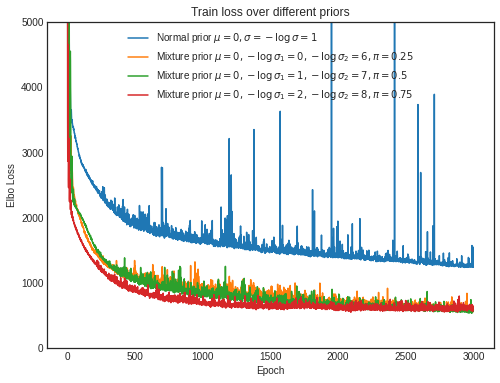

In [5]:
# Plotting training loss
fig_loss = plt.figure(figsize=(8, 6))
plt.plot(training_losses[0, :], label='Normal prior $\mu = 0, \sigma = - \log \sigma = 1$')
plt.plot(training_losses[1, :], label='Mixture prior $\mu = 0, - \log \sigma_1 = 0, - '
                                      '\log \sigma_2 = 6, \pi = 0.25$')
plt.plot(training_losses[2, :], label='Mixture prior $\mu = 0, - \log \sigma_1 = 1, - '
                                      '\log \sigma_2 = 7, \pi = 0.5$')
plt.plot(training_losses[3, :], label='Mixture prior $\mu = 0, - \log \sigma_1 = 2, - '
                                      '\log \sigma_2 = 8, \pi = 0.75$')
plt.title('Train loss over different priors')
plt.xlabel("Epoch")
plt.ylabel("Elbo Loss")
plt.ylim([0, 5000])
plt.legend()
plt.show()
fig_loss.savefig('assets/priors/loss_curves.png')

Comparing MSE errors and storing results

In [6]:
# Loop over results
for idx, exp in enumerate(experiments_prior.keys()):
    print('The MSE error in the test set for {} was: {}'.format(exp, mse_error[idx]))
    print('The avg stdv in the train regime for {} was: {}'.format(exp, mean_std[idx]))

# Finally, save results for future use
np.savetxt('assets/priors/data/loss.txt', training_losses.cpu().detach().numpy(), delimiter=',')
np.savetxt('assets/priors/data/mean.txt', mean_predictive.cpu().detach().numpy(), delimiter=',')
np.savetxt('assets/priors/data/var.txt', var_predictive.cpu().detach().numpy(), delimiter=',')
np.savetxt('assets/priors/data/mse.txt', mse_error.cpu().detach().numpy(), delimiter=',')
np.savetxt('assets/priors/data/std.txt', mean_std.cpu().detach().numpy(), delimiter=',')

The MSE error in the test set for Normal was: 0.19239164888858795
The avg stdv in the train regime for Normal was: 0.06283507496118546
The MSE error in the test set for Mixture1 was: 0.14820341765880585
The avg stdv in the train regime for Mixture1 was: 0.06313756108283997
The MSE error in the test set for Mixture2 was: 0.06460366398096085
The avg stdv in the train regime for Mixture2 was: 0.06542054563760757
The MSE error in the test set for Mixture3 was: 0.5379769206047058
The avg stdv in the train regime for Mixture3 was: 0.06657545268535614


## Training and comparison with Baselines

Evaluation over the four defined baselines, naive linear model, dropout, MC-Dropout and Ensembles

### Evaluation over Linear and Dropout

Evaluation of linear model and dropout. The dataset is exactly the same as the one in the paper.
Training over 3000 epochs and 5 ELBO samples.

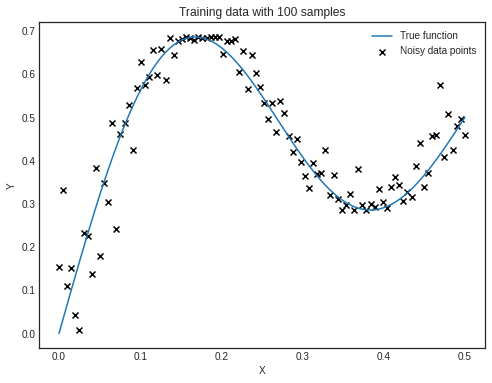

In [7]:
# Defining training and test data
train_samples = 100 # Number of training samples
# Training samples
X_train, y_train = experiment(xmin = 0, xmax = 0.5, samples = train_samples, std = 0.02)
_, y_train_true = experiment(xmin = 0, xmax = 0.5, samples = train_samples, std = 0)
# Test samples (from -0.2 to 1.2)
test_samples = 100
exp_samples = 50
X_test, y_test = experiment(xmin = -0.2, xmax = 1.2, samples = test_samples, std = 0.02)
_, y_test_true = experiment(xmin = -0.2, xmax = 1.2, samples = test_samples, std = 0)

# Visualizing data sample
fig1 = visualize_training(X_train.numpy(), y_train.numpy(), y_train_true.numpy())
fig1.savefig('assets/baselines/training.png')

Training the models

### ----------------------------- ###
# -------- Training Linear -------- #
### ----------------------------- ###


  0%|          | 0/3000 [00:00<?, ?it/s]

### ----------------------------- ###
# ------- Evaluation Linear ------- #
### ----------------------------- ###


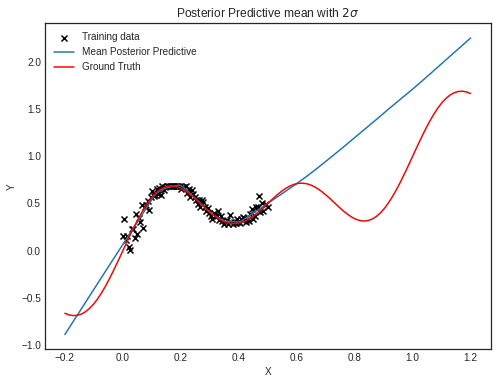

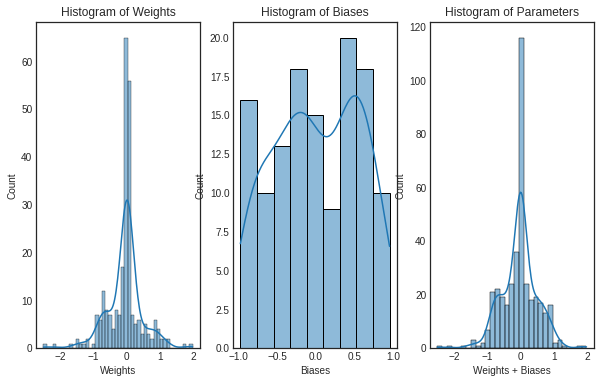

### ----------------------------- ###
# -------- Training Dropout -------- #
### ----------------------------- ###


  0%|          | 0/3000 [00:00<?, ?it/s]

### ----------------------------- ###
# ------- Evaluation Dropout ------- #
### ----------------------------- ###


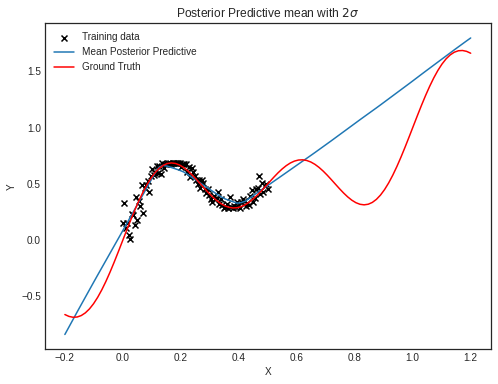

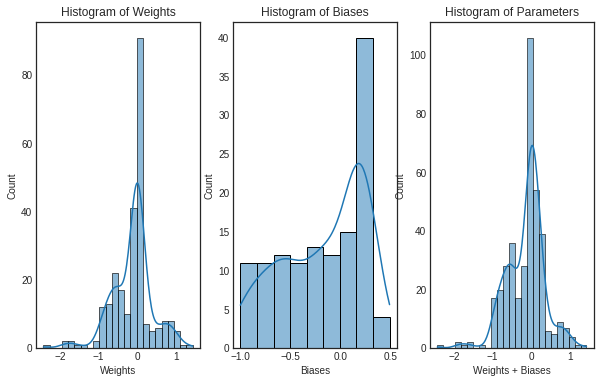

In [8]:
# Defining models
baselines_list = {0: 'Linear', 1: 'Dropout', 2: 'MCdropout', 3: 'Ensembles'}
modelL = BaselineLinearRegressor(hidden_dim=128).to(device)
modelD = BaselineLinRegressorWithDropout(hidden_dim=128, dropout_p=0.2).to(device)

# Defining params
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
# Defining hyper-parameters
epochs = 3000
elbo_samples = 5
# Likelihood variance
ll_var = 0.05**2 # In the paper they always work with the stdv!

# Relevant data bd = Baseline deterministic
training_losses_b = torch.zeros(4, epochs)
mean_predictive_b = torch.zeros(4, test_samples)
var_predictive_b = torch.zeros(4, test_samples)
mse_error_b = torch.zeros(4)
mean_std_b = torch.zeros(4)

for idx, m in enumerate((modelL, modelD)):
    # Model to optimize
    optimizer = optim.Adam(m.parameters(), lr=0.01)
    print('### ----------------------------- ###')
    print('# -------- Training {} -------- #'.format(baselines_list[idx]))
    print('### ----------------------------- ###')
    # Setting model to train
    m.train()
    for epoch in tqdm_notebook(range(epochs)):  # loop over the dataset multiple times
        optimizer.zero_grad()
        # forward + backward + optimize
        y_hat = m(X_train)
        loss = mse(y_hat, y_train)
        loss.backward()
        optimizer.step()
        # Store training losses
        training_losses_b[idx, epoch] = loss.item()

    print('### ----------------------------- ###')
    print('# ------- Evaluation {} ------- #'.format(baselines_list[idx]))
    print('### ----------------------------- ###')
    m.eval()
    # Testing experiment
    y_hat_test = m(X_test)
    mean_predictive_b[idx, :] = torch.squeeze(y_hat_test)
    error = mse(y_hat_test, y_test_true.to(device))
    mse_error_b[idx] = error
    # Save result
    fig_eval = visualize_deterministic(X_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(),
                                       X_test.cpu().detach().numpy(), y_test_true.cpu().detach().numpy(),
                                       y_hat_test.cpu().detach().numpy())
    fig_eval.savefig('assets/baselines/{}_res.png'.format(baselines_list[idx]))
    # Histogram of weights
    _, _, fig_hist = deterministic_histogram(m)
    fig_hist.savefig('assets/baselines/{}_hist.png'.format(baselines_list[idx]))

### Evaluation of MC-Dropout

The number of forward passes are 5 just as in Bayes by backprop.

### ----------------------------- ###
#   ------ Training MCdropout ----- #
### ----------------------------- ###


  0%|          | 0/3000 [00:00<?, ?it/s]

### ----------------------------- ###
#  ------ Evaluation MCdropout ---- #
### ----------------------------- ###


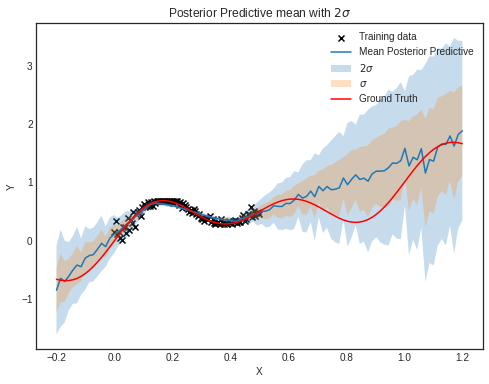

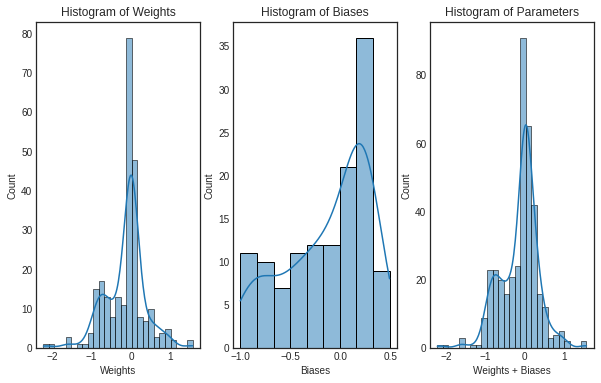

In [9]:
# Defining model
modelMC = BaselineLinRegressorWithDropout(hidden_dim=128, dropout_p=0.2).to(device)
optimizer = optim.Adam(modelMC.parameters(), lr=0.01)

# Set model for training
modelMC.train()
print('### ----------------------------- ###')
print('#   ------ Training {} ----- #'.format(baselines_list[2]))
print('### ----------------------------- ###')
for epoch in tqdm_notebook(range(epochs)):  # loop over the dataset multiple times
    optimizer.zero_grad()
    # forward + backward + optimize
    y_hat = modelMC(X_train)
    loss = mse(y_hat, y_train)
    loss.backward()
    optimizer.step()

    # Store training losses
    training_losses_b[2, epoch] = loss.item()

print('### ----------------------------- ###')
print('#  ------ Evaluation {} ---- #'.format(baselines_list[2]))
print('### ----------------------------- ###')
# Testing
y_samp = torch.zeros((exp_samples, test_samples))
# Testing experiment
for s in range(exp_samples):
    y_hat = modelMC.forward(X_test)
    # Storing results
    y_samp[s, :] = y_hat.reshape(-1)

mean_predictive_b[2, :] = torch.mean(y_samp, dim=0)
var_predictive_b[2, :] = torch.var(y_samp, dim=0)
error = mse(mean_predictive_b[2, :], torch.squeeze(y_test_true))
mse_error_b[2] = error
# Save result
fig_eval = visualize_inference(X_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(),
                               X_test.cpu().detach().numpy(), y_test_true.cpu().detach().numpy(),
                               mean_predictive_b[2, :].cpu().detach().numpy(),
                               var_predictive_b[2, :].cpu().detach().numpy())
fig_eval.savefig('assets/baselines/{}_res.png'.format(baselines_list[2]))
# Histogram of weights
_, _, fig_hist = deterministic_histogram(modelMC)
fig_hist.savefig('assets/baselines/{}_hist.png'.format(baselines_list[2]))

# Computing mean stdv in training data regime
y_samp = torch.zeros((exp_samples, train_samples))
for s in range(exp_samples):
    y_hat = modelMC.forward(X_train)
    # Storing results
    y_samp[s, :] = y_hat.reshape(-1)
predictive_mean, predictive_var = torch.mean(y_samp, dim=0), torch.var(y_samp, dim=0)
avg_std = torch.sqrt(torch.mean(predictive_var))
mean_std_b[2] = avg_std

### Evaluation of Ensembles

Training with 5 Ensembles

### ----------------------------- ###
#   ------ Training Ensembles ----- #
### ----------------------------- ###


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

### ----------------------------- ###
#  ------ Evaluation Ensembles ---- #
### ----------------------------- ###


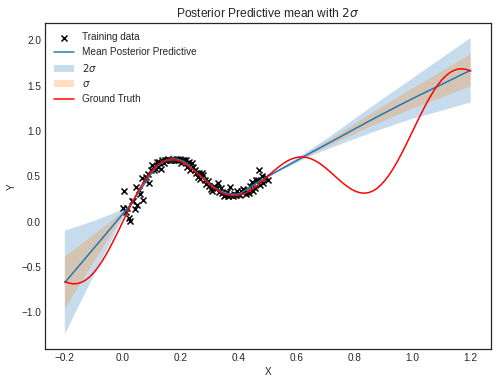

In [10]:
# List to store Ensemble models
models = []
print('### ----------------------------- ###')
print('#   ------ Training {} ----- #'.format(baselines_list[3]))
print('### ----------------------------- ###')
# Training individual model
for _ in range(5):
    modelE = BaselineLinearRegressor(hidden_dim=128).to(device)
    optimizer = optim.Adam(modelE.parameters(), lr=0.01)
    for epoch in tqdm_notebook(range(epochs)):  # loop over the dataset multiple times
        optimizer.zero_grad()
        # forward + backward + optimize
        y_hat = modelE(X_train)
        loss = mse(y_hat, y_train)
        loss.backward()
        optimizer.step()
        # Store training losses - This loss needs to be averaged!
        training_losses_b[3, epoch] += loss.item()
    models.append(copy.deepcopy(modelE))
print('### ----------------------------- ###')
print('#  ------ Evaluation {} ---- #'.format(baselines_list[3]))
print('### ----------------------------- ###')
training_losses_b[3, :] = training_losses_b[3, :] / 5
# Testing
predictive_mean, predictive_var = ensembles_inference(models, X_test)

mean_predictive_b[3, :] = predictive_mean
var_predictive_b[3, :] = predictive_var
error = mse(predictive_mean, torch.squeeze(y_test_true))
mse_error_b[3] = error
# Save result
fig_eval = visualize_inference(X_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(),
                               X_test.cpu().detach().numpy(), y_test_true.cpu().detach().numpy(),
                               predictive_mean.cpu().detach().numpy(),
                               predictive_var.cpu().detach().numpy())
fig_eval.savefig('assets/baselines/{}_res.png'.format(baselines_list[3]))

# Computing mean stdv in training data regime
predictive_mean, predictive_var = ensembles_inference(models, X_train)
avg_std = torch.sqrt(torch.mean(predictive_var))
mean_std_b[3] = avg_std

Visualizing and comparing loss of baselines

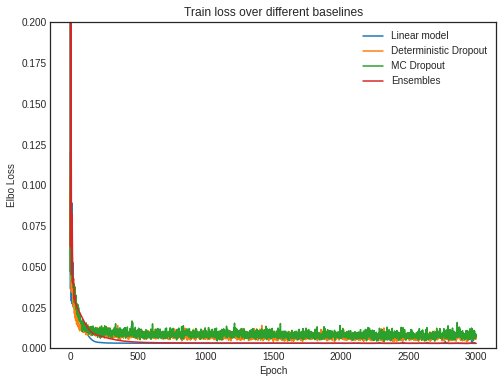

In [11]:
fig_loss = plt.figure(figsize=(8, 6))
plt.plot(training_losses_b[0, :], label='Linear model')
plt.plot(training_losses_b[1, :], label='Deterministic Dropout')
plt.plot(training_losses_b[2, :], label='MC Dropout')
plt.plot(training_losses_b[3, :], label='Ensembles')
plt.title('Train loss over different baselines')
plt.xlabel("Epoch")
plt.ylabel("Elbo Loss")
plt.ylim([0, 0.2])
plt.legend()
plt.show()

fig_loss.savefig('assets/baselines/loss_curves.png')

Comparing MSE errors and storing results of baselines

In [12]:
# For loop to iterate over data
for idx, exp in enumerate(baselines_list.values()):
    print('The MSE error in the test set for {} was: {}'.format(exp, mse_error_b[idx]))
    print('The avg stdv in the train regime for {} was: {}'.format(exp, mean_std_b[idx]))

# # Finally, save results for future use
np.savetxt('assets/baselines/data/loss.txt', training_losses_b.cpu().detach().numpy(), delimiter=',')
np.savetxt('assets/baselines/data/mean.txt', mean_predictive_b.cpu().detach().numpy(), delimiter=',')
np.savetxt('assets/baselines/data/var.txt', var_predictive_b.cpu().detach().numpy(), delimiter=',')
np.savetxt('assets/baselines/data/mse.txt', mse_error_b.cpu().detach().numpy(), delimiter=',')
np.savetxt('assets/baselines/data/std.txt', mean_std_b.cpu().detach().numpy(), delimiter=',')

The MSE error in the test set for Linear was: 0.19535186886787415
The avg stdv in the train regime for Linear was: 0.0
The MSE error in the test set for Dropout was: 0.09917355328798294
The avg stdv in the train regime for Dropout was: 0.0
The MSE error in the test set for MCdropout was: 0.09141989797353745
The avg stdv in the train regime for MCdropout was: 0.058253973722457886
The MSE error in the test set for Ensembles was: 0.09348288178443909
The avg stdv in the train regime for Ensembles was: 0.009345991536974907


### Experiment with Heteroscedastic data

This model was trained with the same training data but now the variance is generated uniformly from 0 to 0.05, the idea
is to validate if the model is able to predict the heteroscedasticity of the data.

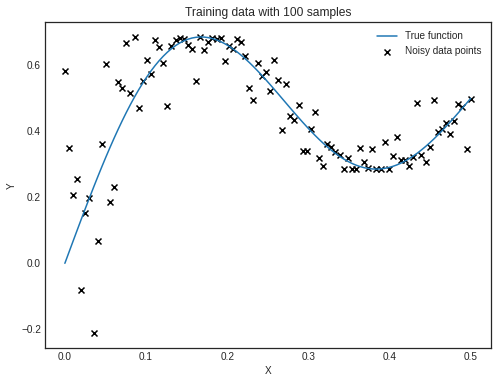

In [13]:
# Defining data
train_samples = 100
# Training samples
X_train, y_train = experiment(xmin = 0, xmax = 0.5, samples = train_samples, std = 0.05, h = True)
_, y_train_true = experiment(xmin = 0, xmax = 0.5, samples = train_samples, std = 0)
# Test samples (from -0.2 to 1.2)
test_samples = 100
exp_samples = 50
X_test, y_test = experiment(xmin = -0.2, xmax = 1.2, samples = test_samples, std = 0.05, h = True)
_, y_test_true = experiment(xmin = -0.2, xmax = 1.2, samples = test_samples, std = 0)
# Visualizing data sample
fig1 = visualize_training(X_train.numpy(), y_train.numpy(), y_train_true.numpy())
fig1.savefig('assets/heteroscedastic/training.png')

Training the models

### ----------------------------- ###
#   ---------- Training ---------   #
### ----------------------------- ###


  0%|          | 0/3000 [00:00<?, ?it/s]

### ----------------------------- ###
#   --------- Evaluating --------   #
### ----------------------------- ###


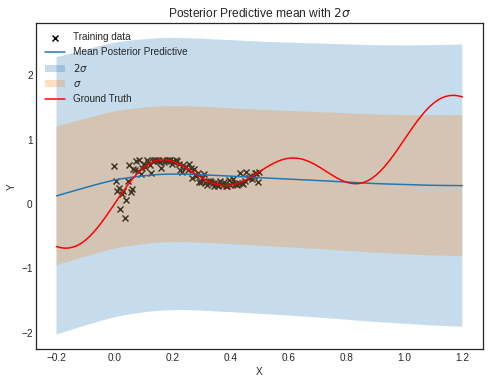

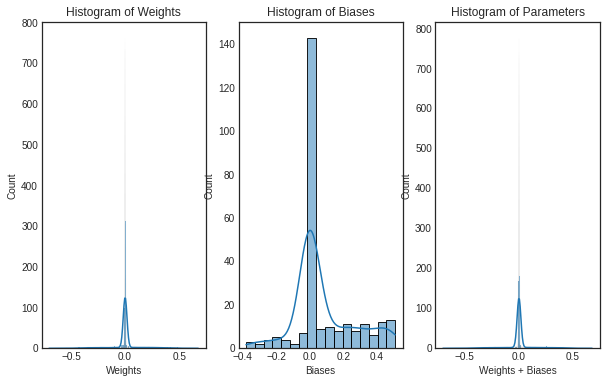

The MSE error in the test set is 0.3303773019985232 and the avg stdv in the train set is: 1.0450088023429014


In [14]:
ll_var = 0.1**2 # 0.05**2 # In the paper they always work with the stdv!
# Using best model found previously
model = BayesianRegressorHeteroscedastic(hidden_dim=128, ll_var=ll_var,
                                         mixture_prior=True,
                                         mixture_params=(0, 6, 1 / 4)).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Defining parameters
elbo_samples = 5
epochs = 3000

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

print('### ----------------------------- ###')
print('#   ---------- Training ---------   #')
print('### ----------------------------- ###')
for epoch in tqdm_notebook(range(epochs)):  # loop over the dataset multiple times
    optimizer.zero_grad()
    # Use mean-ramup
    if epoch > 1000: # Start variance estimation
        loss = model.energy_loss(X_train, y_train, elbo_samples, False)
    else:
        loss = model.energy_loss(X_train, y_train, elbo_samples, True)
    loss.backward()
    optimizer.step()

print('### ----------------------------- ###')
print('#   --------- Evaluating --------   #')
print('### ----------------------------- ###')
y_samp = np.zeros((exp_samples, test_samples))
var_samp = np.zeros((exp_samples, test_samples))
# Testing experiment
for s in range(exp_samples):
    y_hat = model.forward(X_test).cpu().detach().numpy()
    # Storing results
    y_samp[s, :] = y_hat[:,0].reshape(-1)
    # Exponentiate and recover variance
    var_samp[s, :] = np.exp(y_hat[:,1].reshape(-1))
# Computing mean and variance of predictive distribution
predictive_mean, predictive_var = mean_var_predictive(y_samp, var_samp)
# Save result
fig_eval = visualize_inference(X_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(),
                               X_test.cpu().detach().numpy(), y_test_true.cpu().detach().numpy(),
                               predictive_mean, predictive_var)
fig_eval.savefig('assets/heteroscedastic/{}_res.png'.format('Mixture1'))
# Histogram of weights
_, _, fig_hist = weights_histogram(model)
fig_hist.savefig('assets/heteroscedastic/{}_hist.png'.format('Mixture1'))
# Evaluating against true value
error = mse(torch.from_numpy(predictive_mean), torch.squeeze(y_test_true))
# Computing mean stdv in training data regime
y_samp = np.zeros((exp_samples, train_samples))
var_samp = np.zeros((exp_samples, test_samples))
for s in range(exp_samples):
    y_hat = model.forward(X_train).cpu().detach().numpy()
    # Storing results
    y_samp[s, :] = y_hat[:,0].reshape(-1)
    # Exponentiate and recover variance
    var_samp[s, :] = np.exp(y_hat[:,1].reshape(-1))
predictive_mean, predictive_var = mean_var_predictive(y_samp, var_samp)
avg_std = torch.sqrt(torch.mean(torch.from_numpy(predictive_var)))

print('The MSE error in the test set is {} and the avg stdv in the train set is: {}'.format(error, avg_std))

## Evaluating the effect of the likelihood and ELBO Samples

This experiment aims to evaluate the effect of ELBO samples and variance in the likelihood.
The experiment is conducted using the best model's prior. The ELBO samples are 1, 2, 5, 10 and
the the likelihood standard deviation are 0.01, 0.02, 0.05, 0.1, 1.0.

The data used is the same one as the first experiment and the original paper.

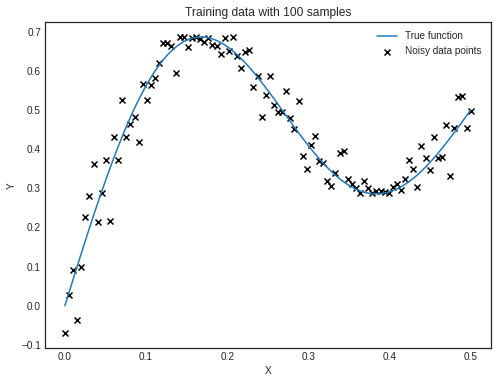

In [15]:
# Defining data
train_samples = 100
# Training samples
X_train, y_train = experiment(xmin = 0, xmax = 0.5, samples = train_samples, std = 0.02)
_, y_train_true = experiment(xmin = 0, xmax = 0.5, samples = train_samples, std = 0)
# Test samples (from -0.3 to 1.0)
test_samples = 100
exp_samples = 50
X_test, y_test = experiment(xmin = -0.2, xmax = 1.2, samples = test_samples, std = 0.02)
_, y_test_true = experiment(xmin = -0.2, xmax = 1.2, samples = test_samples, std = 0)

# Visualizing data sample
fig1 = visualize_training(X_train.numpy(), y_train.numpy(), y_train_true.numpy())
fig1.savefig('assets/likelihood/training.png')

Training the models

### ----------------------------- ###
#   - Training Elbo 1 Var 0.01 -   #
### ----------------------------- ###


  0%|          | 0/3000 [00:00<?, ?it/s]

### ----------------------------- ###
#   - Evaluating Elbo 1 Var 0.01 -   #
### ----------------------------- ###


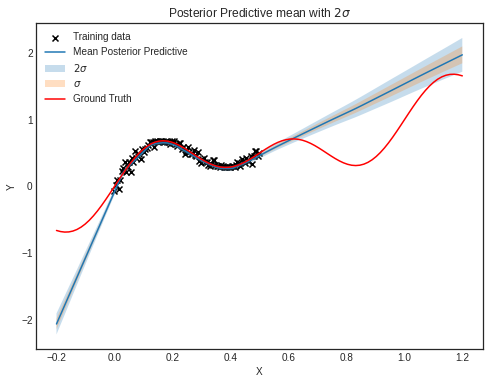

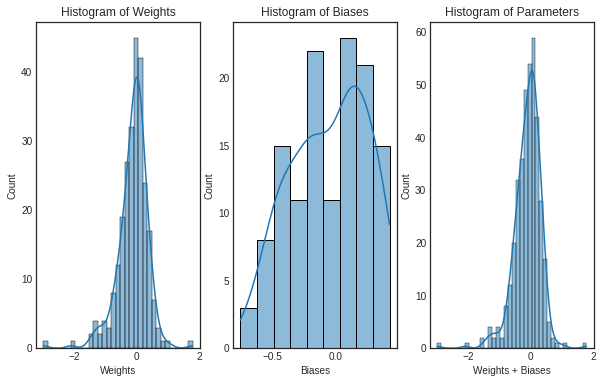

### ----------------------------- ###
#   - Training Elbo 1 Var 0.02 -   #
### ----------------------------- ###


  0%|          | 0/3000 [00:00<?, ?it/s]

### ----------------------------- ###
#   - Evaluating Elbo 1 Var 0.02 -   #
### ----------------------------- ###


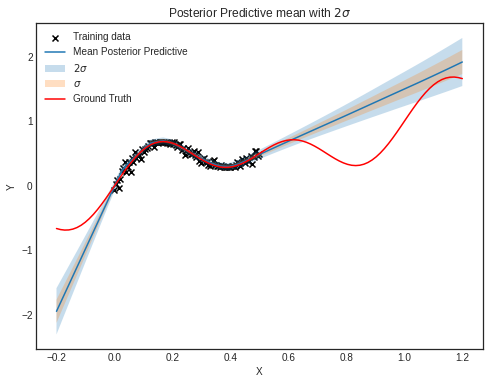

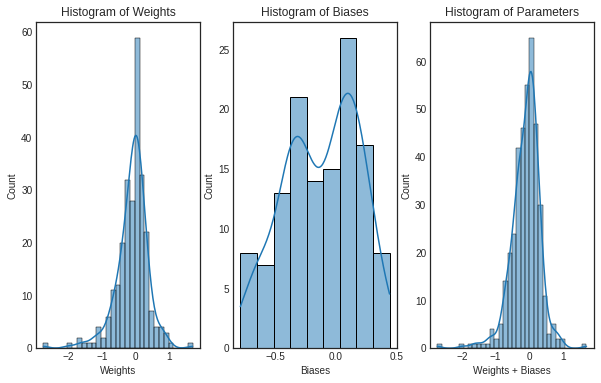

### ----------------------------- ###
#   - Training Elbo 1 Var 0.05 -   #
### ----------------------------- ###


  0%|          | 0/3000 [00:00<?, ?it/s]

### ----------------------------- ###
#   - Evaluating Elbo 1 Var 0.05 -   #
### ----------------------------- ###


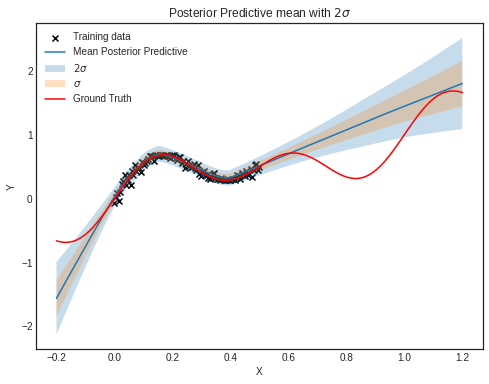

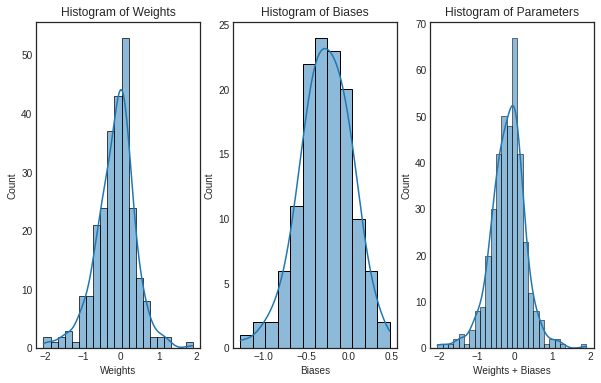

### ----------------------------- ###
#   - Training Elbo 1 Var 0.1 -   #
### ----------------------------- ###


  0%|          | 0/3000 [00:00<?, ?it/s]

### ----------------------------- ###
#   - Evaluating Elbo 1 Var 0.1 -   #
### ----------------------------- ###


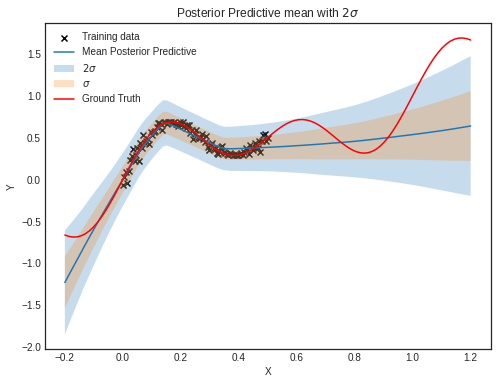

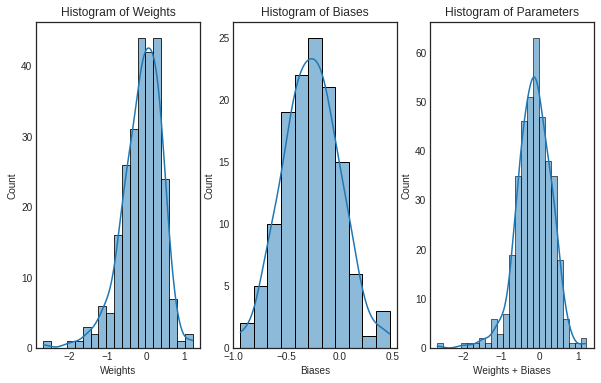

### ----------------------------- ###
#   - Training Elbo 1 Var 1.0 -   #
### ----------------------------- ###


  0%|          | 0/3000 [00:00<?, ?it/s]

### ----------------------------- ###
#   - Evaluating Elbo 1 Var 1.0 -   #
### ----------------------------- ###


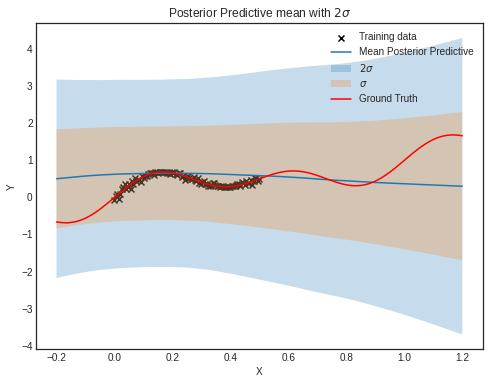

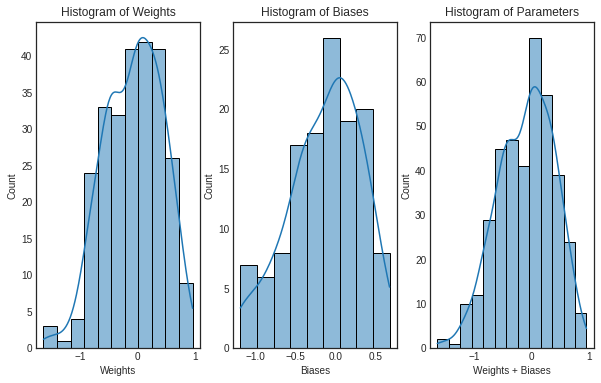

### ----------------------------- ###
#   - Training Elbo 2 Var 0.01 -   #
### ----------------------------- ###


  0%|          | 0/3000 [00:00<?, ?it/s]

### ----------------------------- ###
#   - Evaluating Elbo 2 Var 0.01 -   #
### ----------------------------- ###


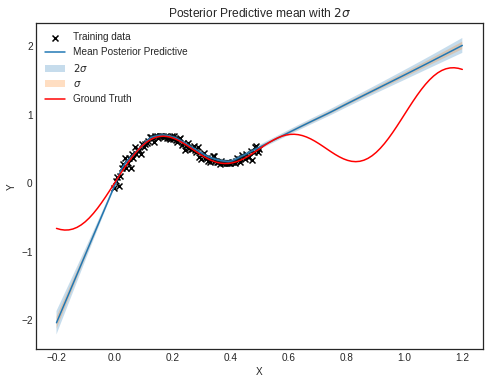

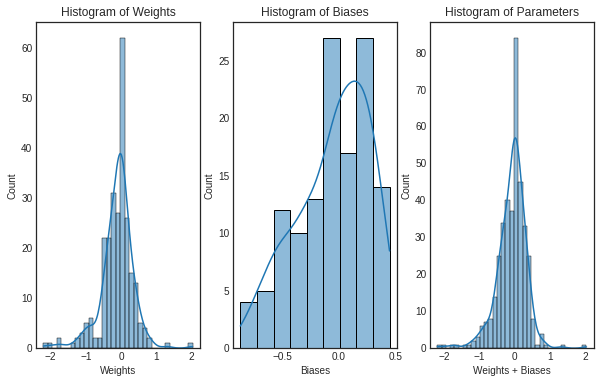

### ----------------------------- ###
#   - Training Elbo 2 Var 0.02 -   #
### ----------------------------- ###


  0%|          | 0/3000 [00:00<?, ?it/s]

### ----------------------------- ###
#   - Evaluating Elbo 2 Var 0.02 -   #
### ----------------------------- ###


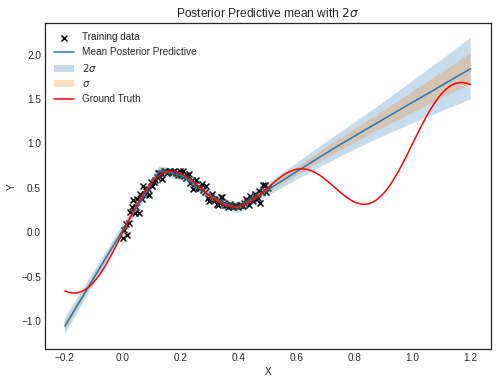

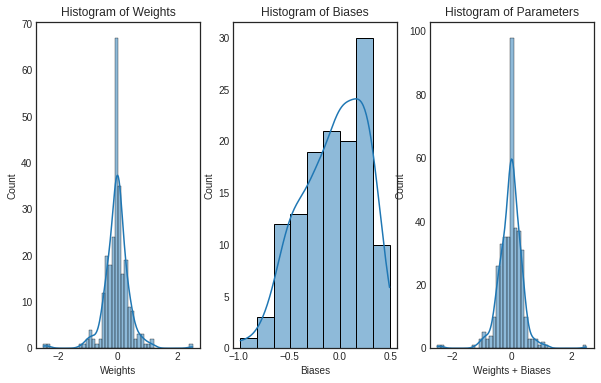

### ----------------------------- ###
#   - Training Elbo 2 Var 0.05 -   #
### ----------------------------- ###


  0%|          | 0/3000 [00:00<?, ?it/s]

### ----------------------------- ###
#   - Evaluating Elbo 2 Var 0.05 -   #
### ----------------------------- ###


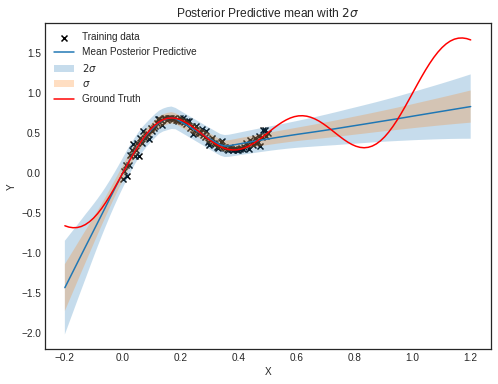

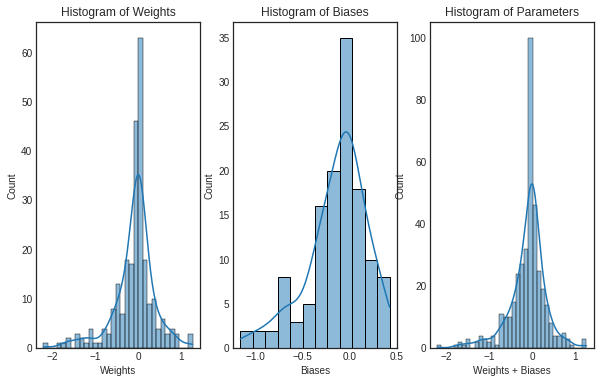

### ----------------------------- ###
#   - Training Elbo 2 Var 0.1 -   #
### ----------------------------- ###


  0%|          | 0/3000 [00:00<?, ?it/s]

### ----------------------------- ###
#   - Evaluating Elbo 2 Var 0.1 -   #
### ----------------------------- ###


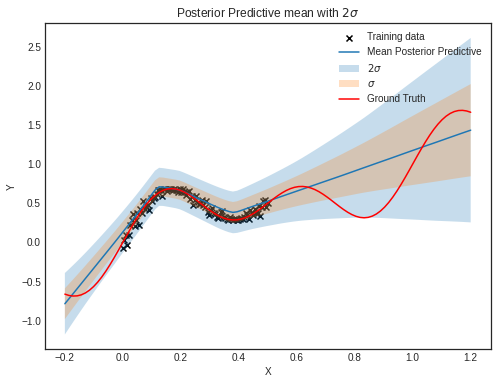

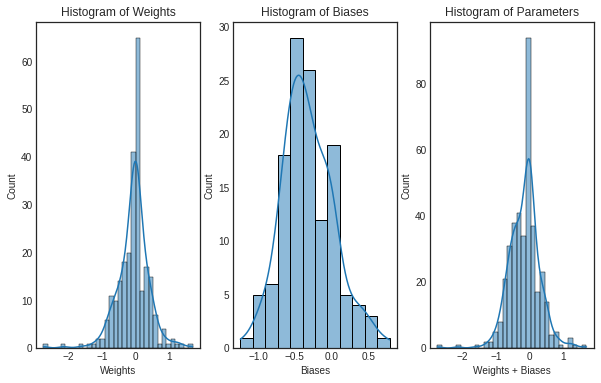

### ----------------------------- ###
#   - Training Elbo 2 Var 1.0 -   #
### ----------------------------- ###


  0%|          | 0/3000 [00:00<?, ?it/s]

### ----------------------------- ###
#   - Evaluating Elbo 2 Var 1.0 -   #
### ----------------------------- ###


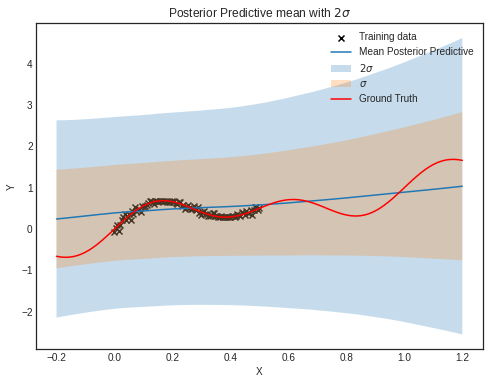

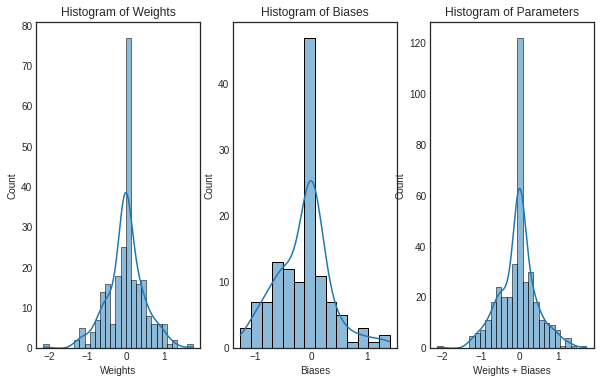

### ----------------------------- ###
#   - Training Elbo 5 Var 0.01 -   #
### ----------------------------- ###


  0%|          | 0/3000 [00:00<?, ?it/s]

### ----------------------------- ###
#   - Evaluating Elbo 5 Var 0.01 -   #
### ----------------------------- ###


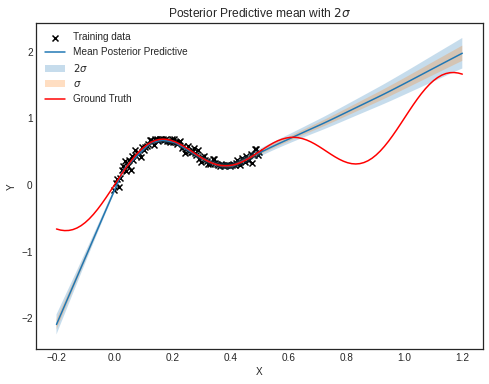

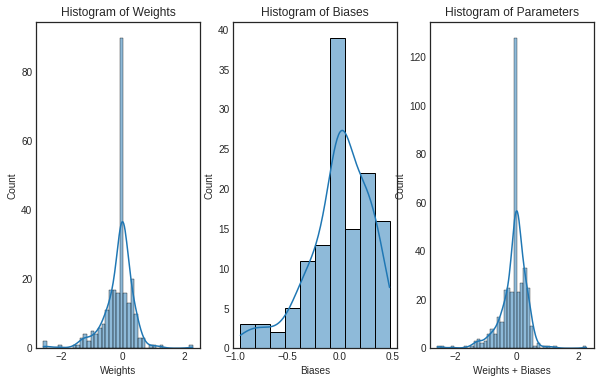

### ----------------------------- ###
#   - Training Elbo 5 Var 0.02 -   #
### ----------------------------- ###


  0%|          | 0/3000 [00:00<?, ?it/s]

### ----------------------------- ###
#   - Evaluating Elbo 5 Var 0.02 -   #
### ----------------------------- ###


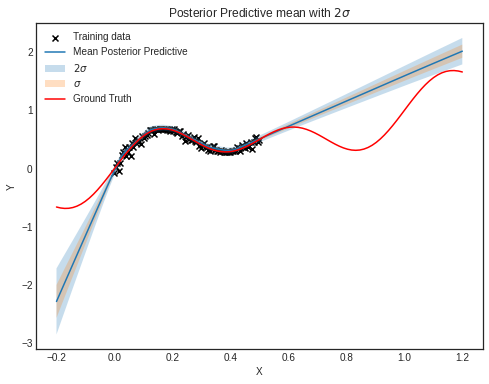

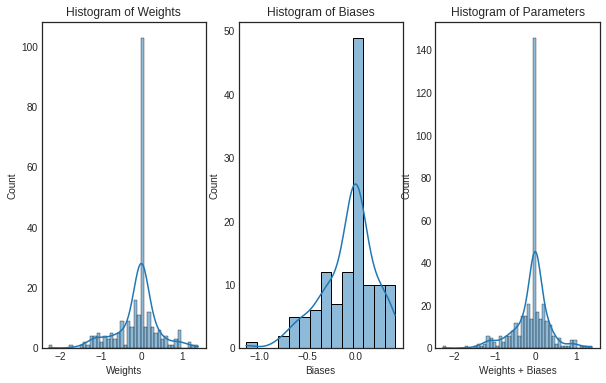

### ----------------------------- ###
#   - Training Elbo 5 Var 0.05 -   #
### ----------------------------- ###


  0%|          | 0/3000 [00:00<?, ?it/s]

### ----------------------------- ###
#   - Evaluating Elbo 5 Var 0.05 -   #
### ----------------------------- ###


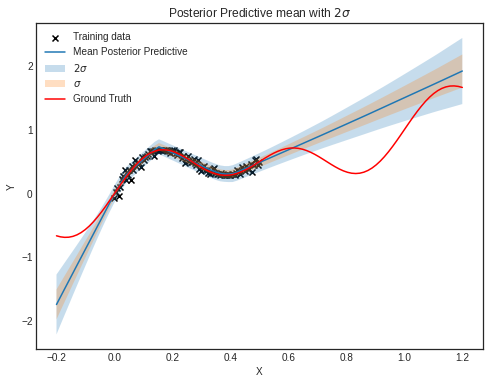

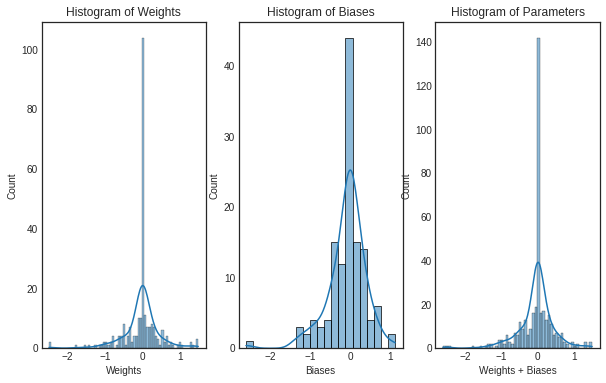

### ----------------------------- ###
#   - Training Elbo 5 Var 0.1 -   #
### ----------------------------- ###


  0%|          | 0/3000 [00:00<?, ?it/s]

### ----------------------------- ###
#   - Evaluating Elbo 5 Var 0.1 -   #
### ----------------------------- ###


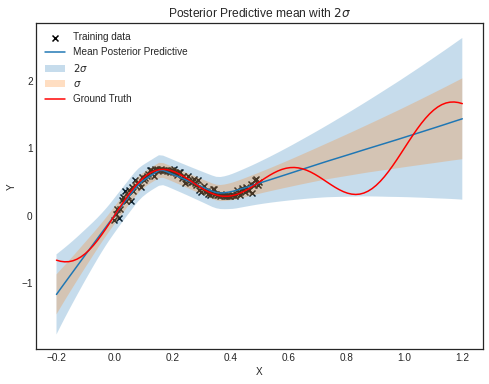

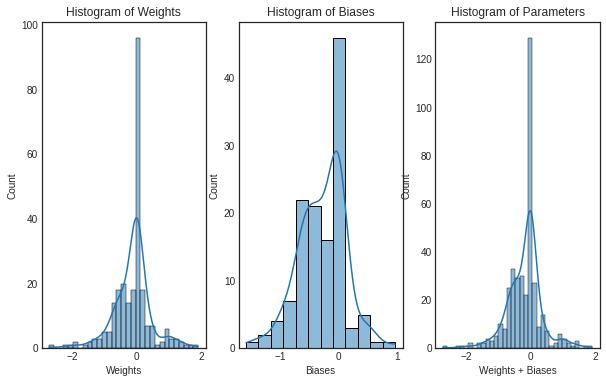

### ----------------------------- ###
#   - Training Elbo 5 Var 1.0 -   #
### ----------------------------- ###


  0%|          | 0/3000 [00:00<?, ?it/s]

### ----------------------------- ###
#   - Evaluating Elbo 5 Var 1.0 -   #
### ----------------------------- ###


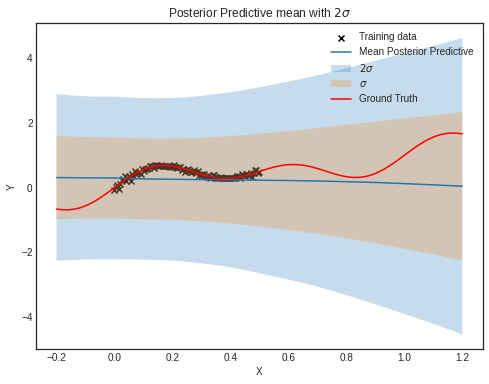

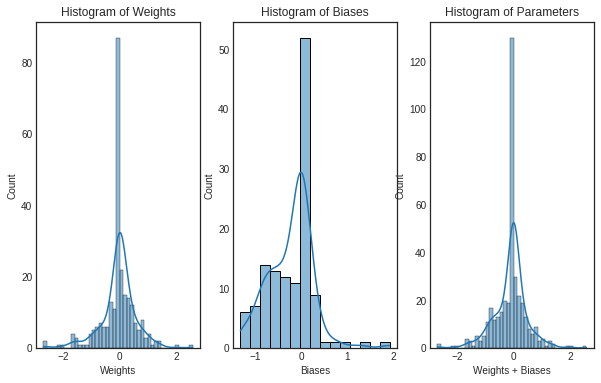

### ----------------------------- ###
#   - Training Elbo 10 Var 0.01 -   #
### ----------------------------- ###


  0%|          | 0/3000 [00:00<?, ?it/s]

### ----------------------------- ###
#   - Evaluating Elbo 10 Var 0.01 -   #
### ----------------------------- ###


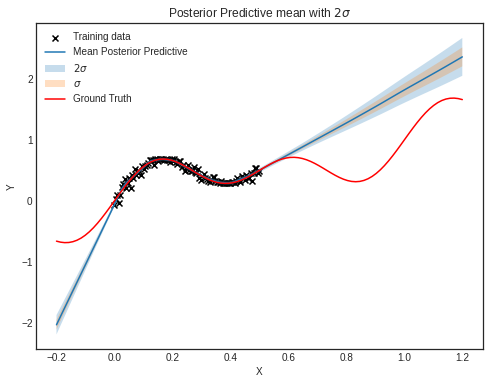

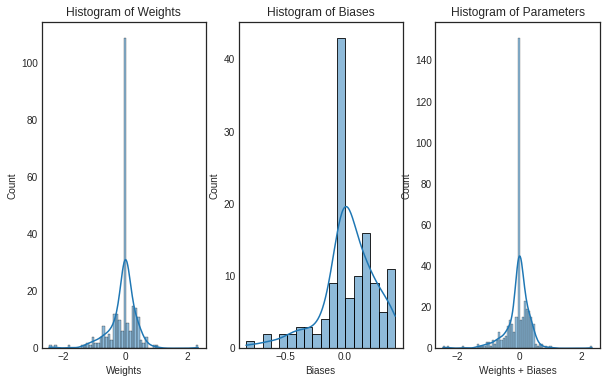

### ----------------------------- ###
#   - Training Elbo 10 Var 0.02 -   #
### ----------------------------- ###


  0%|          | 0/3000 [00:00<?, ?it/s]

### ----------------------------- ###
#   - Evaluating Elbo 10 Var 0.02 -   #
### ----------------------------- ###


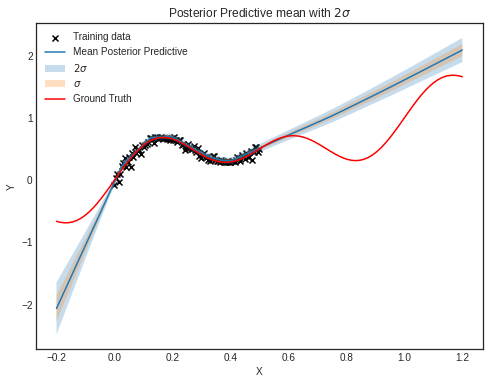

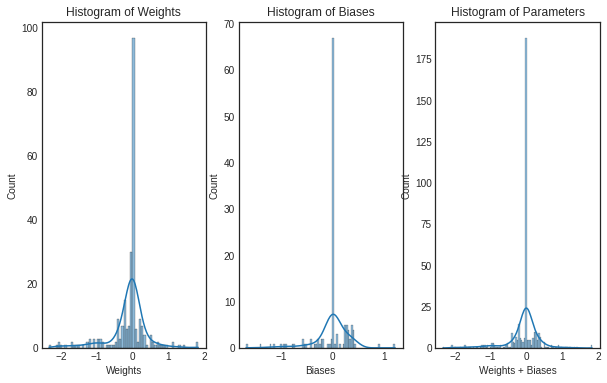

### ----------------------------- ###
#   - Training Elbo 10 Var 0.05 -   #
### ----------------------------- ###


  0%|          | 0/3000 [00:00<?, ?it/s]

### ----------------------------- ###
#   - Evaluating Elbo 10 Var 0.05 -   #
### ----------------------------- ###


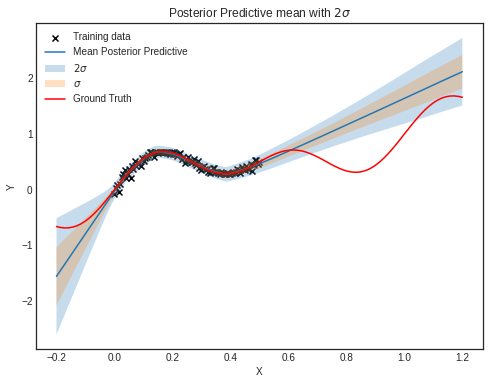

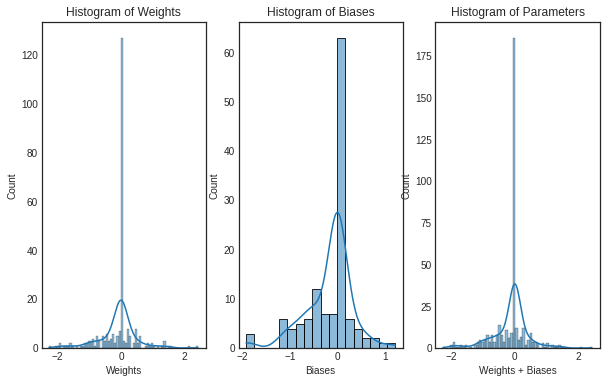

### ----------------------------- ###
#   - Training Elbo 10 Var 0.1 -   #
### ----------------------------- ###


  0%|          | 0/3000 [00:00<?, ?it/s]

### ----------------------------- ###
#   - Evaluating Elbo 10 Var 0.1 -   #
### ----------------------------- ###


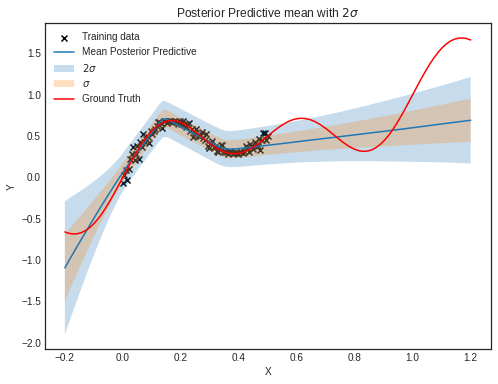

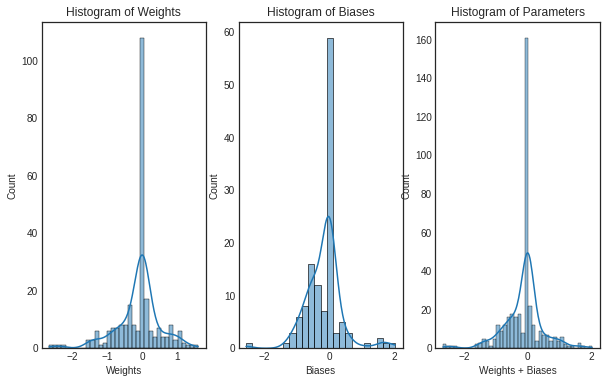

### ----------------------------- ###
#   - Training Elbo 10 Var 1.0 -   #
### ----------------------------- ###


  0%|          | 0/3000 [00:00<?, ?it/s]

### ----------------------------- ###
#   - Evaluating Elbo 10 Var 1.0 -   #
### ----------------------------- ###


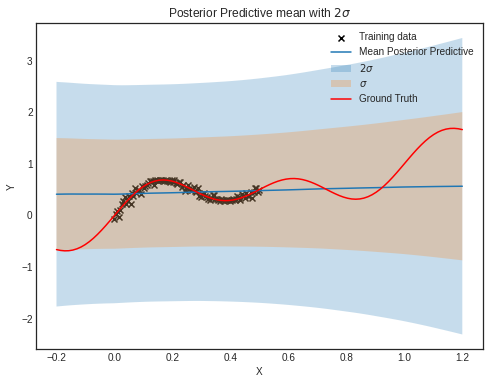

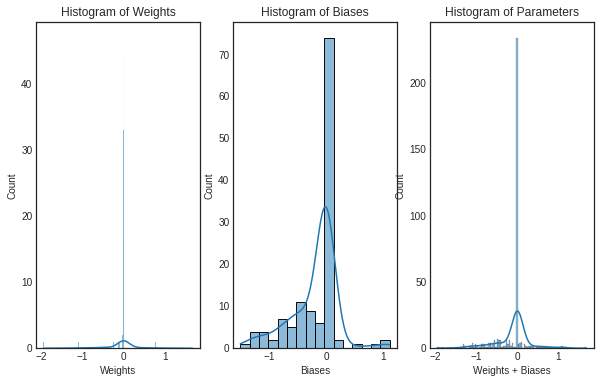

In [16]:
# Experiment params, first argument is elbo samples, the other is likelihood variance
elbo_test = [1, 2, 5, 10]
var_test  = [0.01**2, 0.02**2, 0.05**2, 0.1**2, 1.0**2]
# Create list of parameters to evaluate
elbo_ll_experiments = [(f,s) for f in elbo_test for s in var_test]

# Defining params
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Number of epochs to train
epochs = 3000

# Relevant data
training_losses_ll = torch.zeros(len(elbo_ll_experiments), epochs)
mean_predictive_ll = torch.zeros(len(elbo_ll_experiments), test_samples)
var_predictive_ll = torch.zeros(len(elbo_ll_experiments), test_samples)
mse_error_ll = torch.zeros(len(elbo_ll_experiments))
mean_std_ll = torch.zeros(len(elbo_ll_experiments))

# Main training loop
for idx, (elbo_samples, ll_var) in enumerate(elbo_ll_experiments):
    # Likelihood variance
    model = BayesianRegressor(hidden_dim=128, ll_var=ll_var,
                              mixture_prior=True, mixture_params=(0, 6, 1 / 4)).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    print('### ----------------------------- ###')
    print('#   - Training Elbo {} Var {} -   #'.format(elbo_samples, np.sqrt(ll_var)))
    print('### ----------------------------- ###')
    for epoch in tqdm_notebook(range(epochs)):  # loop over the dataset multiple times
        optimizer.zero_grad()
        # forward + backward + optimize
        loss = model.energy_loss(X_train, y_train, elbo_samples)
        loss.backward()
        optimizer.step()

        # Store training losses
        training_losses_ll[idx, epoch] = loss.item()

    print('### ----------------------------- ###')
    print('#   - Evaluating Elbo {} Var {} -   #'.format(elbo_samples, np.sqrt(ll_var)))
    print('### ----------------------------- ###')
    y_samp = np.zeros((exp_samples, test_samples))
    # Testing experiment
    for s in range(exp_samples):
        y_hat = model.forward(X_test).cpu().detach().numpy()
        # Storing results
        y_samp[s, :] = y_hat.reshape(-1)
    # Computing mean and variance of predictive distribution
    predictive_mean, predictive_var = mean_var_predictive(y_samp, np.array(ll_var))
    mean_predictive_ll[idx, :] = torch.from_numpy(predictive_mean)
    var_predictive_ll[idx, :] = torch.from_numpy(predictive_var)
    # Save result
    fig_eval = visualize_inference(X_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(),
                                   X_test.cpu().detach().numpy(), y_test_true.cpu().detach().numpy(),
                                   predictive_mean, predictive_var)
    fig_eval.savefig('assets/likelihood/elbo{}_like{}_res.png'.format(elbo_samples, ll_var))
    # Histogram of weights
    _, _, fig_hist = weights_histogram(model)
    fig_hist.savefig('assets/likelihood/elbo{}_like{}_hist.png'.format(elbo_samples, ll_var))
    # Evaluating against true value
    error = mse(torch.from_numpy(predictive_mean), torch.squeeze(y_test_true))
    mse_error_ll[idx] = error
    # Computing mean stdv in training data regime
    y_samp = np.zeros((exp_samples, train_samples))
    for s in range(exp_samples):
        y_hat = model.forward(X_train).cpu().detach().numpy()
        # Storing results
        y_samp[s, :] = y_hat.reshape(-1)
    predictive_mean, predictive_var = mean_var_predictive(y_samp, np.array(ll_var))
    avg_std = torch.sqrt(torch.mean(torch.from_numpy(predictive_var)))
    mean_std_ll[idx] = avg_std

Visualizing and comparing loss curves and results

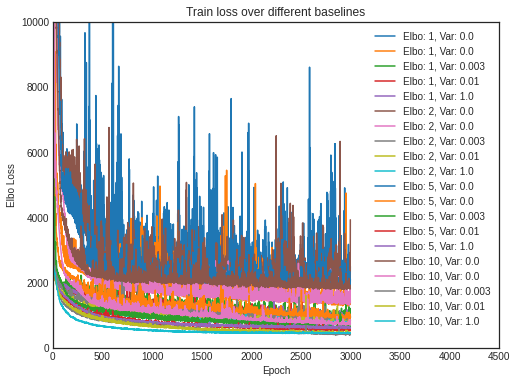

In [17]:
# Plotting losses
fig_loss = plt.figure(figsize=(8, 6))
for i, vals in enumerate(elbo_ll_experiments):
    plt.plot(training_losses_ll[i, :], label='Elbo: {}, Var: {}'.format(vals[0], np.round(vals[1], 3)))

plt.title('Train loss over different baselines')
plt.xlabel("Epoch")
plt.ylabel("Elbo Loss")
plt.ylim([0, 10000])
plt.xlim([0, 4500])
plt.legend()
plt.show()

fig_loss.savefig('assets/likelihood/loss_curves.png')

Comparing MSE errors and storing results

In [18]:
# Iterating over experiments
for idx, vals in enumerate(elbo_ll_experiments):
    print('The MSE error in the test set for {} was: {}'.format(vals, mse_error_ll[idx]))
    print('The avg stdv in the train regime for {} was: {}'.format(vals, mean_std_ll[idx]))

# Finally, save results for future use
np.savetxt('assets/likelihood/data/loss.txt', training_losses_ll.cpu().detach().numpy(), delimiter=',')
np.savetxt('assets/likelihood/data/mean.txt', mean_predictive_ll.cpu().detach().numpy(), delimiter=',')
np.savetxt('assets/likelihood/data/var.txt', var_predictive_ll.cpu().detach().numpy(), delimiter=',')
np.savetxt('assets/likelihood/data/mse.txt', mse_error_ll.cpu().detach().numpy(), delimiter=',')
np.savetxt('assets/likelihood/data/std.txt', mean_std_ll .cpu().detach().numpy(), delimiter=',')

The MSE error in the test set for (1, 0.0001) was: 0.21008600294589996
The avg stdv in the train regime for (1, 0.0001) was: 0.01575300469994545
The MSE error in the test set for (1, 0.0004) was: 0.1821010261774063
The avg stdv in the train regime for (1, 0.0004) was: 0.0279290322214365
The MSE error in the test set for (1, 0.0025000000000000005) was: 0.13304771482944489
The avg stdv in the train regime for (1, 0.0025000000000000005) was: 0.06539718806743622
The MSE error in the test set for (1, 0.010000000000000002) was: 0.14742553234100342
The avg stdv in the train regime for (1, 0.010000000000000002) was: 0.1341797113418579
The MSE error in the test set for (1, 1.0) was: 0.4041433334350586
The avg stdv in the train regime for (1, 1.0) was: 1.3036483526229858
The MSE error in the test set for (2, 0.0001) was: 0.22351738810539246
The avg stdv in the train regime for (2, 0.0001) was: 0.015554510988295078
The MSE error in the test set for (2, 0.0004) was: 0.11522050946950912
The avg std

## Evaluating the model in a real-world dataset

The dataset to use is the [NASA](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise)
dataset. The experiment works by using the best model with mixture prior and predicting the variance of
this regression dataset.

In [19]:
# Obtaining dataset
!wget -c https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat -O nasa.dat

--2021-12-06 21:55:18--  https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



Processing dataset

In [20]:
data = np.loadtxt('nasa.dat', unpack = True).T
X_train, X_test, y_train, y_test = train_test_split(data[:,:5], data[:, -1],
                                                    test_size=0.2, random_state=42)
# Scaling data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training the model

### ----------------------------- ###
#   ---------- Training ---------   #
### ----------------------------- ###


  0%|          | 0/5000 [00:00<?, ?it/s]

### ----------------------------- ###
#   --------- Evaluating --------   #
### ----------------------------- ###


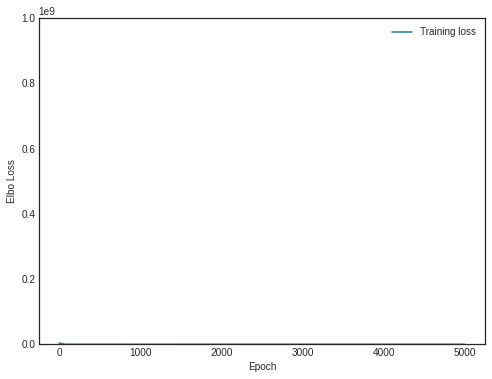

The MSE error of the model is: 4.800737549908918
The number of samples within the uncertainty range for 1 sigma are: 0.6478405315614618 percent
The number of samples within the uncertainty range for 2 sigma are: 0.9102990033222591 percent


In [21]:
# Defining log-likelihood and model
ll_var = 1.5**2 # Tried 0.05, 0.1, 0.25, 0.5
model = BayesianRegressor(input_dim=5, hidden_dim=128, ll_var=ll_var,
                          mixture_prior=True, mixture_params=(0, 6, 1 / 4)).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Hyperparameters
elbo_samples = 5
epochs = 5000
test_samples = 100
exp_samples = 50

X_train_scaled = torch.from_numpy(X_train_scaled).float().to(device)
X_test_scaled = torch.from_numpy(X_test_scaled).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)
# List to store values
loss_vals = torch.zeros(epochs)

print('### ----------------------------- ###')
print('#   ---------- Training ---------   #')
print('### ----------------------------- ###')
# Training loop
for epoch in tqdm_notebook(range(epochs)):
    optimizer.zero_grad()
    # forward + backward + optimize
    loss = model.energy_loss(X_train_scaled, y_train, elbo_samples)
    loss.backward()
    optimizer.step()
    # Store training losses
    loss_vals[epoch] = loss.item()

print('### ----------------------------- ###')
print('#   --------- Evaluating --------   #')
print('### ----------------------------- ###')
fig_loss = plt.figure(figsize=(8, 6))
plt.plot(loss_vals, label='Training loss')
plt.xlabel("Epoch")
plt.ylabel("Elbo Loss")
plt.ylim([0, 1e9])
plt.legend()
plt.show()

# Evaluation
y_samp = np.zeros((exp_samples, y_test.shape[0]))
# Testing experiment
for s in range(exp_samples):
    y_hat = model.forward(X_test_scaled).cpu().detach().numpy()
    # Storing results
    y_samp[s, :] = y_hat.reshape(-1)
# Computing mean and variance of predictive distribution
predictive_mean, predictive_var = mean_var_predictive(y_samp, np.array(ll_var))
predictive_mean = torch.from_numpy(predictive_mean).to(device)
predictive_var = torch.from_numpy(predictive_var).to(device)

# Evaluating against true value
error = mse(predictive_mean, torch.squeeze(y_test))
print('The MSE error of the model is: {}'.format(error))

# Evaluation
predictive_std = torch.sqrt(predictive_var).cpu().detach().numpy()
y_true = torch.squeeze(y_test).cpu().detach().numpy()
predictive_mean = predictive_mean.cpu().detach().numpy()

# Computing elements within range
one_stdv = np.logical_and(y_true<=predictive_mean + 1 * predictive_std,
                          y_true>=predictive_mean - 1 * predictive_std)
two_stdv = np.logical_and(y_true<=predictive_mean + 2 * predictive_std,
                          y_true>=predictive_mean - 2 * predictive_std)

print('The number of samples within the uncertainty range for 1 sigma are: {} percent'.format(np.mean(one_stdv)))
print('The number of samples within the uncertainty range for 2 sigma are: {} percent'.format(np.mean(two_stdv)))